### CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = 'cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

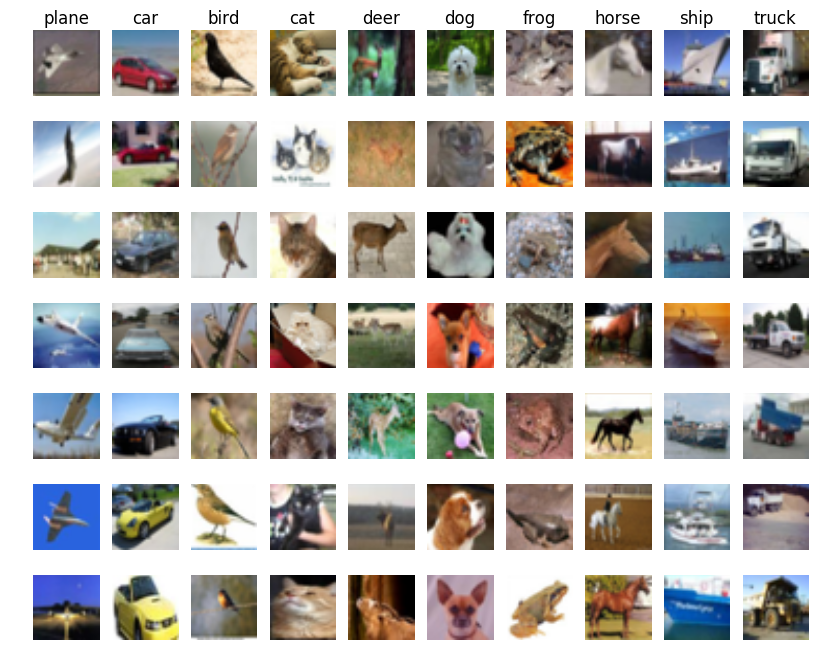

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Раньше сверточные сети были небольшой глубины (меньше 20 слоев). Сейчас научились делать глубокие нейронки (больше 150 слоев) с помощью линков и активаций на разных глубинах.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Могут начать затухать градиенты, первые слои не будут обучаться. Долго обучаются. Могут кончиться деньги на сервера. Исчезнет личная жизнь.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Нейросеточка будет как Эллочка-Людоедка: выучиться ну уж очень плохо. А сеточка хочет много данных. Можно использовать предобученные нейронные сети, сделать файн тюннинг либо использовать веса этой сетки для начальных весов новой сеточки. Второй вариант решения: насемплировать данных бутстрепом, поворотом картинок, наложением шумов и др. преобразованиями.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [5]:
import theano

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [6]:
import lasagne

In [7]:
from theano import tensor as T

In [8]:
from lasagne.nonlinearities import *

In [9]:
input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [10]:
# from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers.dnn import Pool2DDNNLayer as Pool2DLayer
from lasagne.layers import batch_norm
from lasagne.layers import DropoutLayer
from lasagne.layers import ElemwiseSumLayer
# from lasagne.layers import Pool2DLayer
from lasagne.layers import FlattenLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
# from lasagne.layers import PadLayer
# from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer
# from lasagne.nonlinearities import softmax, rectify
# from lasagne.layers import batch_norm

In [11]:
def Build_small_block(net, dim, width=1, first_stride=1, dropout=0.0):
    left = Build_left33(net, dim, width, first_stride, dropout=0.0)
    
    right = ConvLayer(net, dim * width, filter_size=(1, 1),
                                stride=(first_stride, first_stride),
                                pad=(0, 0),
                                nonlinearity=None
                     )
    print("Build_small_block left: ", left.output_shape)
    print("Build_small_block right: ", right.output_shape)
    net_1 = ElemwiseSumLayer([left, right])
    print("Build_small_block: ", net_1.output_shape)
    return net_1

In [12]:
def batch_relu(net):
    left = batch_norm(net)
    left = NonlinearityLayer(left, nonlinearity=rectify)
    print("batch_relu: ", left.output_shape)
    return left

In [13]:
def Build_big_block(net, dim, width=1, first_stride=1, dropout=0.0):
    left = batch_relu(net)
    left = Build_left33(left, dim, width, first_stride, dropout)
    right = net
    print("Build_big_block left: ", left.output_shape)
    print("Build_big_block right: ", right.output_shape)
    net_1 = ElemwiseSumLayer([left, right])
    print("Build_big_block: ", net_1.output_shape)
    return net_1

In [14]:
def Build_left33(net, dim, width=1, first_stride=1, dropout=0.0):
    left = ConvLayer(net, dim * width,
                    filter_size=(3,3),
                    stride=(first_stride,first_stride),
                    pad=(1, 1),
                    nonlinearity=None)

    left = DropoutLayer(left, p=dropout)


    left = batch_relu(left)
    left = ConvLayer(left,
                      dim * width,
                      filter_size=(3, 3),
                      stride=(1, 1),
                      pad=(1, 1),
                     nonlinearity=None)
    left = DropoutLayer(left, p=dropout)
    print("Build_left33: ", left.output_shape)
    return left

In [15]:
def init_network(input_X):
    net = InputLayer(shape=(None, 3, 32, 32),
                                    input_var=input_X)
    net = ConvLayer(net,
                    16,
                    filter_size=(3,3),
                    stride=(1, 1),
                    pad=(1, 1),
                    nonlinearity=rectify
                    )
    net = batch_norm(net)
    net = NonlinearityLayer(net, nonlinearity=rectify)
    print("init_network: ", net.output_shape)
    return net

In [16]:
def finilization(net):
    net1 = batch_relu(net)
    net1 = Pool2DLayer(net,
                       pool_size=8,
                       stride=(1, 1),
                       ignore_border=True,
                       pad=(3, 3),
                       mode='average_exc_pad')  # average pooling
    print("after pooling: ", net1.output_shape)
    net1 = FlattenLayer(net1, outdim=2)
    print("after flatten: ", net1.output_shape)

    net1 = DenseLayer(net1, num_units=10, nonlinearity=softmax)
    print("finally, ", net1.output_shape)
    return net1

In [17]:
def build_net(input_X, config):
    activation_1 = init_network(input_X)
    merge1 = Build_small_block(activation_1, dim=16, width=config['width'], dropout=config['dropout'])
    merge2 = Build_big_block(merge1, dim=16, width=config['width'], dropout=config['dropout'])
    merge3 = Build_big_block(merge2, dim=16, width=config['width'], dropout=config['dropout'])
    merge4 = Build_big_block(merge3, dim=16, width=config['width'], dropout=config['dropout'])
    
    activation9 = batch_relu(merge4)
    merge5 = Build_small_block(activation9, dim=32, first_stride=2, width=config['width'], dropout=config['dropout'])
    merge6 = Build_big_block(merge5, dim=32, width=config['width'], dropout=config['dropout'])
    merge7 = Build_big_block(merge6, dim=32, width=config['width'], dropout=config['dropout'])
    merge8 = Build_big_block(merge7, dim=32, width=config['width'], dropout=config['dropout'])

    activation17 = batch_relu(merge8)
    merge9 = Build_small_block(activation17, dim=64, first_stride=2, width=config['width'], dropout=config['dropout'])
    merge10 = Build_big_block(merge9, dim=64, width=config['width'], dropout=config['dropout'])
    merge11 = Build_big_block(merge10, dim=64, width=config['width'], dropout=config['dropout'])
    merge12 = Build_big_block(merge11, dim=64, width=config['width'], dropout=config['dropout'])
    net = finilization(merge12)
    return net

In [18]:
config = {'dropout': 0.3, 'width':10, 'lr':0.005, 'l2_reg': 0.00005}

In [19]:
net = build_net(input_X, config)

('init_network: ', (None, 16, 32, 32))
('batch_relu: ', (None, 160, 32, 32))
('Build_left33: ', (None, 160, 32, 32))
('Build_small_block left: ', (None, 160, 32, 32))
('Build_small_block right: ', (None, 160, 32, 32))
('Build_small_block: ', (None, 160, 32, 32))
('batch_relu: ', (None, 160, 32, 32))
('batch_relu: ', (None, 160, 32, 32))
('Build_left33: ', (None, 160, 32, 32))
('Build_big_block left: ', (None, 160, 32, 32))
('Build_big_block right: ', (None, 160, 32, 32))
('Build_big_block: ', (None, 160, 32, 32))
('batch_relu: ', (None, 160, 32, 32))
('batch_relu: ', (None, 160, 32, 32))
('Build_left33: ', (None, 160, 32, 32))
('Build_big_block left: ', (None, 160, 32, 32))
('Build_big_block right: ', (None, 160, 32, 32))
('Build_big_block: ', (None, 160, 32, 32))
('batch_relu: ', (None, 160, 32, 32))
('batch_relu: ', (None, 160, 32, 32))
('Build_left33: ', (None, 160, 32, 32))
('Build_big_block left: ', (None, 160, 32, 32))
('Build_big_block right: ', (None, 160, 32, 32))
('Build_big_

In [20]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, beta, gamma, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b]


In [21]:
%%time
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y)
loss = loss.mean() + config['l2_reg']*lasagne.regularization.regularize_layer_params(lasagne.layers.get_all_layers(net),
                                                                              lasagne.regularization.l2
                                                                             )
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

CPU times: user 44.3 ms, sys: 52 µs, total: 44.4 ms
Wall time: 43.7 ms


In [22]:
sh_lr = theano.shared(lasagne.utils.floatX(config['lr']))
updates = lasagne.updates.momentum(loss,
                                   all_weights,
                                   learning_rate=sh_lr,
                                   momentum=0.9)

In [23]:
%%time
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)

CPU times: user 1min 18s, sys: 1.75 s, total: 1min 20s
Wall time: 1min 20s


In [24]:
train_fun(X_train[1:5,:,:,:], y_train[1:5])

[array(4.23948860168457, dtype=float32), array(0.0)]

### Вот и всё, пошли её учить

In [26]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Процесс обучения

In [ ]:
from datetime import datetime
import time
print(datetime.now())
with open("Malyshev_WRN_28_10.log", "a+") as f:
    print('Config: {}'.format(config))
    f.write('Config: {}'.format(config))
    f.write('Time: {}'.format(datetime.now()))
num_epochs = 5 #количество проходов по данным

batch_size = 50 #размер мини-батча
i = 0
max_iter = 10000000
for epoch in xrange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
        inputs, targets = batch
#         print(targets)
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        if i % 50 == 0:
            print('training: ', train_err, train_acc)
        i += (i + 1) % max_iter
            

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size, augment=True):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    with open("Malyshev_WRN_28_10.log", "a+") as f:
        f.write('Time: {}\n'.format(datetime.now()))
        if epoch == 0:
            f.write("\n-------------NEW ERA -----------\n")
            f.write("Config {}\n".format(config))
        f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
        f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
        f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
        f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

2017-04-26 23:25:47.305234
Config: {'width': 10, 'dropout': 0.3, 'lr': 0.005, 'l2_reg': 5e-05}


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


('training: ', 59.720890045166016, 0.12)
Epoch 1 of 5 took 2392.214s
  training loss (in-iteration):		146.584950
  train accuracy:		10.85 %
  validation accuracy:		10.75 %


In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Добивочка

In [ ]:
import time

num_epochs = 20 #

batch_size = 50 #размер мини-батча
i = 0
max_iter = 10000000
for epoch in xrange(now_epoch, num_epochs+now_epoch):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        if i % 250 == 0:
            print('training: ', train_err, train_acc)
        i += (i + 1) % max_iter
            

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
        if epoch == 0:
            f.write("-------------EXTRA_LEARNING -----------\n")
        f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
        f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
        f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
        f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    if ((train_acc / train_batches * 100) - (val_acc / val_batches * 100) > 10):
        new_lr = max(0.0000001, sh_lr.get_value() * 0.1)
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Decressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    else:
        new_lr = max(0.0000001, 0.01/np.sqrt(epoch + 1))
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Incressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 